# Predicting the impact of Trump's Trade related tweets on the US stock market

Stock market is always unpredictable. Banks and traders are always looking out to improve their trading strategies. Any information or indicators that able to give an edge or advantage is always sought after. The President of United States, Donald Trump currently has 87.2 millions followers on Twitter under the handle of @realDonaldTrump. Lucky for traders, the President is highly active on his twitter account and isn't shy about tweeting his views basically on anything. By understanding the impact(positive/negative) of President Trump’s tweets has in the Stock market, this will improve one’s investing/trading strategies.

I will analyze President Trump's tweets begining from his presidency in 2017. Using natural language processing(NLP) tools such as topic modeling to identify tweets that are trade/market related and each tweet is then assigned a sentiment score which will be used in the modelling. I will build a classification model that will look into the text features of President Trump tweets and how it can be classified to have positive or negative impact on the market. As this model can be use as an indicator for buy signals, we want to want have high accuracy on both true positive and negative therefore our success will be measured by the AUC/ROC score. 

In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_lg
#!pip install pyldavis
#!pip install vaderSentiment
#conda install -c conda-forge wordcloud

# Data Cleaning 

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

pd.set_option("display.max_rows", 9999)
pd.set_option("display.max_columns", 9999)
plt.style.use('seaborn')


### Tweets data

In [3]:
#load the data from json
tweets = pd.read_json("../datasets/trump_tweets.json")

In [4]:
tweets.head(10)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-08 02:57:08+00:00,65210,418654,0.0,1314037081392525312
1,Twitter for iPhone,https://t.co/yPrw5jqgGV,2020-10-08 02:56:46+00:00,20225,88262,0.0,1314036989226778624
2,Twitter for iPhone,https://t.co/wHQx2qd8q2,2020-10-08 02:49:05+00:00,23424,79991,0.0,1314035056441257984
3,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-08 02:40:57+00:00,26438,70249,0.0,1314033009293656064
4,Twitter for iPhone,https://t.co/4Wv5cCFEns https://t.co/kMvBv6Pu9I,2020-10-08 02:24:56+00:00,11798,40743,0.0,1314028978806624256
5,Twitter for iPhone,https://t.co/rxqPqR4uqZ,2020-10-08 02:23:49+00:00,22052,93256,0.0,1314028699084259328
6,Twitter for iPhone,https://t.co/xGevgI2wTO,2020-10-08 02:20:57+00:00,16190,54819,0.0,1314027975185182720
7,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-08 02:20:18+00:00,16920,0,1.0,1314027813318594560
8,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-08 02:11:50+00:00,9380,0,1.0,1314025683174203392
9,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-08 02:09:36+00:00,28864,73680,0.0,1314025119497551872


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23357 entries, 0 to 23356
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   source          23357 non-null  object             
 1   text            23357 non-null  object             
 2   created_at      23357 non-null  datetime64[ns, UTC]
 3   retweet_count   23357 non-null  int64              
 4   favorite_count  23357 non-null  int64              
 5   is_retweet      23299 non-null  float64            
 6   id_str          23357 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [6]:
tweets["is_retweet"].isnull().sum()

58

In [7]:
tweets[tweets["is_retweet"].isnull()]

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
20836,Twitter for iPhone,Thanks to all of the Republican and Democratic...,2018-01-09 22:51:50+00:00,11718,58068,NaN,950862709599465472
20837,Twitter for iPhone,"It was my great honor to sign H.R. 267, the “M...",2018-01-09 20:17:17+00:00,17249,73554,NaN,950823813868122112
20838,Twitter for iPhone,"On behalf of the American people, THANK YOU to...",2018-01-09 17:11:23+00:00,26793,112613,NaN,950777029816963072
20839,Twitter for iPhone,"We are fighting for our farmers, for our count...",2018-01-08 23:19:47+00:00,22044,104968,NaN,950507353094356992
20840,Twitter for iPhone,"In every decision we make, we are honoring Ame...",2018-01-08 22:59:37+00:00,17769,81027,NaN,950502279785959424
20841,Twitter for iPhone,We have been working every day to DELIVER for ...,2018-01-08 22:58:13+00:00,11561,57809,NaN,950501926227136512
20842,Twitter for iPhone,Can’t wait to be back in the amazing state of ...,2018-01-08 19:06:40+00:00,10242,54355,NaN,950443653666713600
20843,Twitter for iPhone,African American unemployment is the lowest ev...,2018-01-08 14:20:25+00:00,34648,132122,NaN,950371619247153152
20844,Twitter for iPhone,"...Clinton in the WH, doubling down on Barack ...",2018-01-08 03:24:23+00:00,18904,83265,NaN,950206523690639360
20845,Twitter for iPhone,“His is turning out to be an enormously conseq...,2018-01-08 03:23:39+00:00,16880,82631,NaN,950206338411499520


After investigating the null values in "is_retweet", we have conclude that they are not retweets and hence will assign 0 to it.

In [8]:
tweets["is_retweet"].fillna(0, inplace=True)

In [9]:
tweets["is_retweet"].isnull().sum()

0

In [10]:
#drop the id_str column which does not provide useful information
tweets.drop(columns=["id_str"], inplace=True)

Donald trump seems to tweet alot of pictures/videos which are url links that at this point we are unable to interpret, hence we decided to remove url links from the text as it does not provide any information. In this inital cleaning we also remove punctuations and the twitter handler sign @ and html code &amp;

In [11]:
#create function to clean the text
def clean_text(text):
    return " ".join(re.sub(r"(@[a-zA-Z0-9_]+)|([^A-Za-z0-9])|(amp;)|(\w+://.+)" , " ", text).split()).lower()


In [12]:
tweets['clean_text'] = tweets['text'].apply(lambda text: clean_text(text))

In [13]:
#remove rows that have spaces only
for i in range(len(tweets['clean_text'])):
    if len(tweets['clean_text'][i]) < 1:
        tweets.drop(index=i, inplace=True)
        

In [14]:
#reset the index
tweets.reset_index(drop=True, inplace=True)

In [15]:
tweets.shape

(22394, 7)

In [16]:
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,clean_text
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-08 02:57:08+00:00,65210,418654,0.0,mike pence won big
1,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-08 02:40:57+00:00,26438,70249,0.0,2010 to 2016 under kamala harris s watch as to...
2,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-08 02:20:18+00:00,16920,0,1.0,rt
3,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-08 02:11:50+00:00,9380,0,1.0,rt
4,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-08 02:09:36+00:00,28864,73680,0.0,moderator cut off mike pence while discussing ...


The data collected was on UTC time, as we are trying to predict if trump tweet has any impact on the stock market, we have to convert to the same timezone which is US/Eastern.

In [17]:
#create a function to convert timezone
def convert_time(time):
    return time.astimezone(tz="US/Eastern")

In [18]:
tweets["created_at"]  = tweets["created_at"].apply(lambda x: convert_time(x))

In [19]:
tweets["year"] = tweets["created_at"].dt.year

In [20]:
tweets["month"] = tweets["created_at"].dt.month

In [21]:
tweets["day"] = tweets["created_at"].dt.day

In [22]:
tweets["year_month"] = tweets["created_at"].dt.strftime("%Y-%m")

In [23]:
tweets["day_of_week"] = tweets["created_at"].dt.weekday

In [24]:
tweets["hour_of_day"] = tweets["created_at"].dt.strftime("%H")

In [25]:
tweets.shape

(22394, 13)

Trump also have alot of retweets, by extracting the handlers of his retweet might give us more insights. 

In [26]:
def find_handle(text):
        handle = re.search(r"(@[\w]+)", text)
        
        if handle != None:
            return re.search(r"(@[\w]+)", text).group(0)
        else:
            return None
                       

In [27]:
tweets["handle"] = tweets["text"].apply(lambda text: find_handle(text))

Count the number of words each tweets 

In [28]:
tweets['word_count'] = tweets['clean_text'].apply(lambda text : len(text.split()))

In [29]:
tweets.shape

(22394, 15)

In [30]:
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,clean_text,year,month,day,year_month,day_of_week,hour_of_day,handle,word_count
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-07 22:57:08-04:00,65210,418654,0.0,mike pence won big,2020,10,7,2020-10,2,22,None,4
1,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-07 22:40:57-04:00,26438,70249,0.0,2010 to 2016 under kamala harris s watch as to...,2020,10,7,2020-10,2,22,None,11
2,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-07 22:20:18-04:00,16920,0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1
3,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-07 22:11:50-04:00,9380,0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1
4,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-07 22:09:36-04:00,28864,73680,0.0,moderator cut off mike pence while discussing ...,2020,10,7,2020-10,2,22,@VP,28


### Market data

S&P 500 daily data colleted from yahoo finance from 2016-01-04 to 2020-10-08. 

In [31]:
market = pd.read_csv("../datasets/SPY.csv")

In [32]:
market.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,200.490005,201.029999,198.589996,201.020004,183.291626,222353500
1,2016-01-05,201.399994,201.899994,200.050003,201.360001,183.601654,110845800
2,2016-01-06,198.339996,200.059998,197.600006,198.820007,181.285645,152112600
3,2016-01-07,195.330002,197.440002,193.589996,194.050003,176.936371,213436100
4,2016-01-08,195.190002,195.850006,191.580002,191.919998,174.994186,209817200


Adjusted close take into consideration on the dividends and stock splits. To make things simple would drop this column and use only close.

In [33]:
#drop column 'adj close'
market.drop(columns='Adj Close', inplace=True)

In [34]:
#lower case columns name
market.columns = market.columns.str.lower()

In [35]:
#convert datte to datetime dtype
market['date'] = pd.to_datetime(market['date'])

In [36]:
#create a column to find the % change for the day 
market['change_pc'] = market['close'].pct_change()

Create a column indicating 1 as positive and 0 for negative changes for the day. This will then be integrated into tweets data as label which is used for classification

In [37]:
market['target'] = [1 if num >= 0 else 0 for num in market['change_pc']]

In [38]:
market.head()

,date,open,high,low,close,volume,change_pc,target
0,2016-01-04,200.490005,201.029999,198.589996,201.020004,222353500,NaN,0
1,2016-01-05,201.399994,201.899994,200.050003,201.360001,110845800,0.001691,1
2,2016-01-06,198.339996,200.059998,197.600006,198.820007,152112600,-0.012614,0
3,2016-01-07,195.330002,197.440002,193.589996,194.050003,213436100,-0.023992,0
4,2016-01-08,195.190002,195.850006,191.580002,191.919998,209817200,-0.010977,0


In [39]:
#create a 1 day lag for pct change 
market['prev_change']  = market.change_pc.shift()

In [40]:
market.head()

,date,open,high,low,close,volume,change_pc,target,prev_change
0,2016-01-04,200.490005,201.029999,198.589996,201.020004,222353500,NaN,0,NaN
1,2016-01-05,201.399994,201.899994,200.050003,201.360001,110845800,0.001691,1,NaN
2,2016-01-06,198.339996,200.059998,197.600006,198.820007,152112600,-0.012614,0,0.001691
3,2016-01-07,195.330002,197.440002,193.589996,194.050003,213436100,-0.023992,0,-0.012614
4,2016-01-08,195.190002,195.850006,191.580002,191.919998,209817200,-0.010977,0,-0.023992


We will be using data only from the day Trump got his presidency, hence will drop dates before 2017-01-20

In [41]:
market = market.loc[market['date'] >= '2017-01-20']

In [42]:
market.reset_index(drop=True, inplace=True)
market.head()

,date,open,high,low,close,volume,change_pc,target,prev_change
0,2017-01-20,226.699997,227.309998,225.970001,226.740005,129168600,0.003674,1,-0.003705
1,2017-01-23,226.740005,226.809998,225.270004,226.149994,75061600,-0.002602,0,0.003674
2,2017-01-24,226.399994,228.080002,226.270004,227.600006,95555300,0.006412,1,-0.002602
3,2017-01-25,228.699997,229.570007,228.509995,229.570007,84437700,0.008656,1,0.006412
4,2017-01-26,229.399994,229.710007,229.009995,229.330002,59970700,-0.001045,0,0.008656


### Trading days

The US stock market open from Monday to Friday, 930am to 430pm. In order to classify if tweets have impact on the stock market, a label will be assigned to each tweet on how the stock market perform on the next trading day (t+1). 1 will be positive and 0 for negative changes in the closing price. Example if President Trump tweeted on 2017-01-20 (friday), we will look at the percentage change of prices on 2017-01-23 (monday) and assign the label accordingly. 1 if the changes is positive else 0. 

In [43]:
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,clean_text,year,month,day,year_month,day_of_week,hour_of_day,handle,word_count
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-07 22:57:08-04:00,65210,418654,0.0,mike pence won big,2020,10,7,2020-10,2,22,None,4
1,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-07 22:40:57-04:00,26438,70249,0.0,2010 to 2016 under kamala harris s watch as to...,2020,10,7,2020-10,2,22,None,11
2,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-07 22:20:18-04:00,16920,0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1
3,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-07 22:11:50-04:00,9380,0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1
4,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-07 22:09:36-04:00,28864,73680,0.0,moderator cut off mike pence while discussing ...,2020,10,7,2020-10,2,22,@VP,28


In [44]:
tweets['date'] = tweets['created_at'] + datetime.timedelta(days=1)

In [45]:
tweets['date'] = tweets['date'].dt.date

In [46]:
tweets['date'] = pd.to_datetime(tweets['date'] )

In [47]:
#merge the change column to the tweet dataframe
tweets = pd.merge(tweets, market[['date', 'prev_change' ,'change_pc','target']], how='outer')


In [48]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22398 entries, 0 to 22397
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   source          22394 non-null  object                    
 1   text            22394 non-null  object                    
 2   created_at      22394 non-null  datetime64[ns, US/Eastern]
 3   retweet_count   22394 non-null  float64                   
 4   favorite_count  22394 non-null  float64                   
 5   is_retweet      22394 non-null  float64                   
 6   clean_text      22394 non-null  object                    
 7   year            22394 non-null  float64                   
 8   month           22394 non-null  float64                   
 9   day             22394 non-null  float64                   
 10  year_month      22394 non-null  object                    
 11  day_of_week     22394 non-null  float64               

In [49]:
#na values here are non trading days (not in market data)
#Therefore by filling the values forward it takes the next trading day price changes. 
tweets['target'].fillna(method='pad', inplace=True)
tweets['change_pc'].fillna(method='pad', inplace=True)
tweets['prev_change'].fillna(method='pad', inplace=True)

In [50]:
tweets.rename(columns={'date': 'trade_date'}, inplace=True)

In [51]:
tweets.shape

(22398, 19)

In [52]:
tweets.isnull().sum()

source                4
text                  4
created_at            4
retweet_count         4
favorite_count        4
is_retweet            4
clean_text            4
year                  4
month                 4
day                   4
year_month            4
day_of_week           4
hour_of_day           4
handle            10715
word_count            4
trade_date            0
prev_change           0
change_pc             0
target                0
dtype: int64

In [53]:
len(tweets[tweets.text.isnull()])

4

After merging the dataframe, there are 4 rows of na values. This is because President Trump did not tweet on those dates. Hence will drop the rows.

In [54]:
tweets.dropna(subset=['text'], inplace=True)

In [55]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22394 entries, 0 to 22393
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   source          22394 non-null  object                    
 1   text            22394 non-null  object                    
 2   created_at      22394 non-null  datetime64[ns, US/Eastern]
 3   retweet_count   22394 non-null  float64                   
 4   favorite_count  22394 non-null  float64                   
 5   is_retweet      22394 non-null  float64                   
 6   clean_text      22394 non-null  object                    
 7   year            22394 non-null  float64                   
 8   month           22394 non-null  float64                   
 9   day             22394 non-null  float64                   
 10  year_month      22394 non-null  object                    
 11  day_of_week     22394 non-null  float64               

In [56]:
tweets = tweets.astype({'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int', 
                        'hour_of_day': 'int', 'word_count': 'int', 'target': 'int'})

In [57]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22394 entries, 0 to 22393
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   source          22394 non-null  object                    
 1   text            22394 non-null  object                    
 2   created_at      22394 non-null  datetime64[ns, US/Eastern]
 3   retweet_count   22394 non-null  float64                   
 4   favorite_count  22394 non-null  float64                   
 5   is_retweet      22394 non-null  float64                   
 6   clean_text      22394 non-null  object                    
 7   year            22394 non-null  int64                     
 8   month           22394 non-null  int64                     
 9   day             22394 non-null  int64                     
 10  year_month      22394 non-null  object                    
 11  day_of_week     22394 non-null  int64                 

In [58]:
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,clean_text,year,month,day,year_month,day_of_week,hour_of_day,handle,word_count,trade_date,prev_change,change_pc,target
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-07 22:57:08-04:00,65210.0,418654.0,0.0,mike pence won big,2020,10,7,2020-10,2,22,None,4,2020-10-08,0.017407,0.008863,1
1,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-07 22:40:57-04:00,26438.0,70249.0,0.0,2010 to 2016 under kamala harris s watch as to...,2020,10,7,2020-10,2,22,None,11,2020-10-08,0.017407,0.008863,1
2,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-07 22:20:18-04:00,16920.0,0.0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1,2020-10-08,0.017407,0.008863,1
3,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-07 22:11:50-04:00,9380.0,0.0,1.0,rt,2020,10,7,2020-10,2,22,@Mike_Pence,1,2020-10-08,0.017407,0.008863,1
4,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-07 22:09:36-04:00,28864.0,73680.0,0.0,moderator cut off mike pence while discussing ...,2020,10,7,2020-10,2,22,@VP,28,2020-10-08,0.017407,0.008863,1


In [59]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         937 non-null    datetime64[ns]
 1   open         937 non-null    float64       
 2   high         937 non-null    float64       
 3   low          937 non-null    float64       
 4   close        937 non-null    float64       
 5   volume       937 non-null    int64         
 6   change_pc    937 non-null    float64       
 7   target       937 non-null    int64         
 8   prev_change  937 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 66.0 KB


In [60]:
market.set_index('date', inplace=True)

In [61]:
tweets.target.value_counts(normalize=True)

1    0.571939
0    0.428061
Name: target, dtype: float64

Now we have all the tweets labeled, we observed there's a balance between both classes with 57% of his tweets have positive and 43% have negative impact on the market.

# EDA

### Total Number Tweets

In [62]:
len(tweets)

22394

### Tweets count by year

In [63]:
tweets[["text", "year", "is_retweet"]].groupby(["year", "is_retweet"]).count()

text
year is_retweet      
2017 0.0         2162
     1.0          301
2018 0.0         3051
     1.0          464
2019 0.0         6663
     1.0          884
2020 0.0         8533
     1.0          336

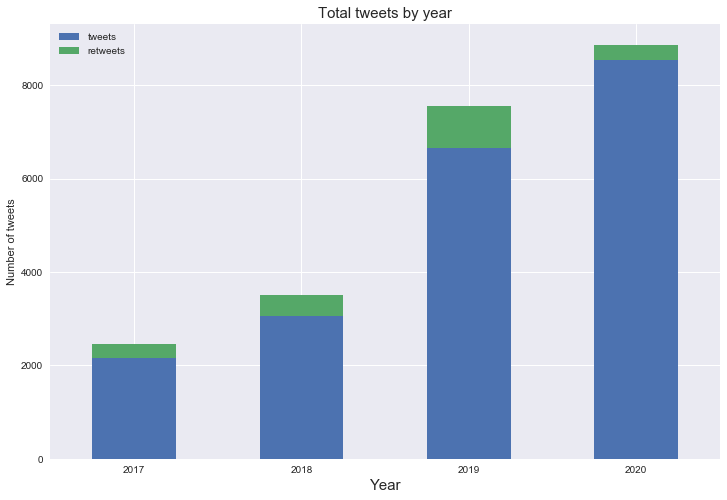

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
total_tweets = tweets[["text", "year", "is_retweet"]].groupby(["year", "is_retweet"]).count().unstack()
total_tweets.plot(kind="bar", ax=ax, stacked=True)
ax.set_title("Total tweets by year", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.set_xticklabels(total_tweets.index, rotation=0)
ax.set_ylabel("Number of tweets")
ax.legend(labels=["tweets", "retweets"])

From here we observed that Donald Trump has increase his number of tweets over the years since he became US president in 2017. This same goes for his retweets where we see an increase numbers since 2017 however there's an decrease in 2020, this might be due to the fact that the data collected for 2020 is until Oct. 

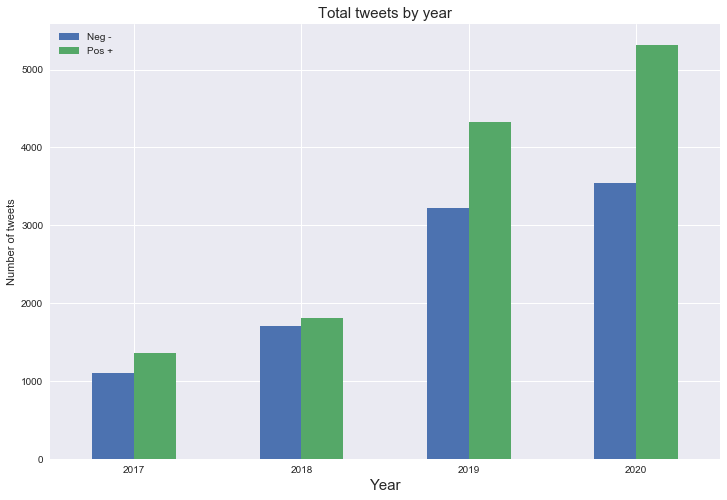

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
total_tweets = tweets[['text','year', 'target']].groupby(['year', 'target']).count().unstack()
total_tweets.plot(kind="bar", ax=ax)
ax.set_title("Total tweets by year", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.set_xticklabels(total_tweets.index, rotation=0)
ax.set_ylabel("Number of tweets")
ax.legend(labels=["Neg -", "Pos +"]);


### Tweets count by month

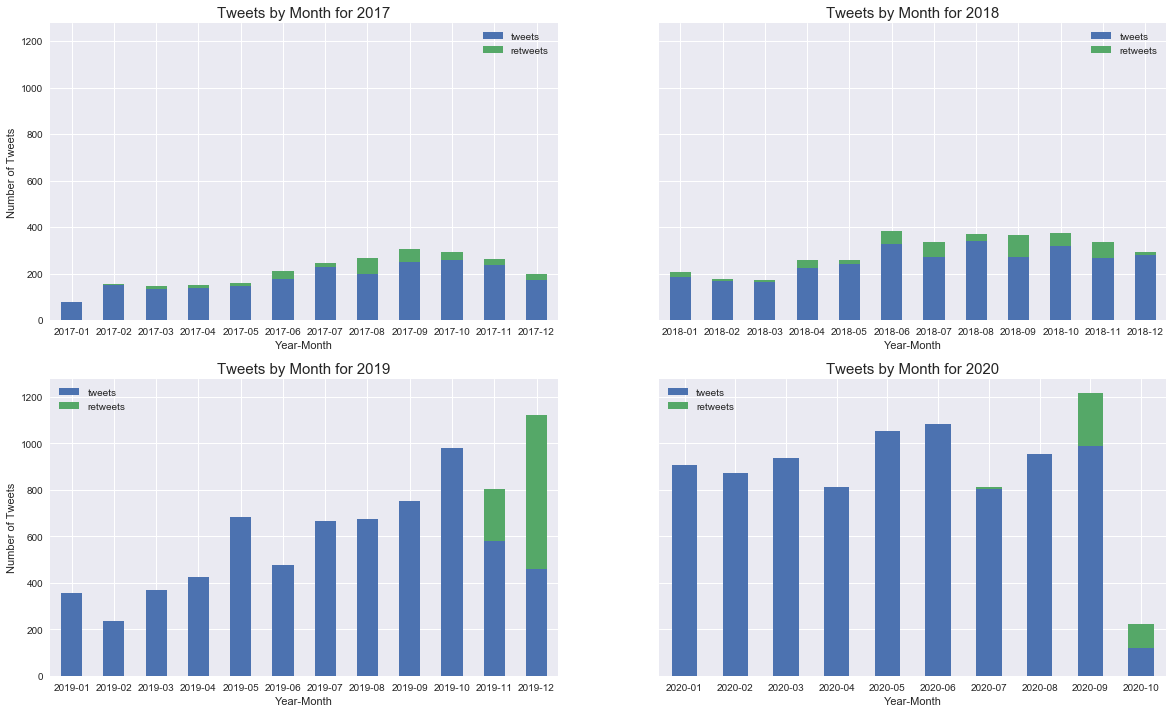

In [66]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    year_month = tweets[tweets["year"] == year]
    year_month = year_month[["year_month", "text", "is_retweet"]].groupby(["year_month", "is_retweet"]).count().unstack()
    year_month.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_xticklabels(year_month.index, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by Month for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    


In general, Trump posted more tweets in the last quarter of each year. One interesting finding is that in 2019 December he retweeted more than his own tweets. 

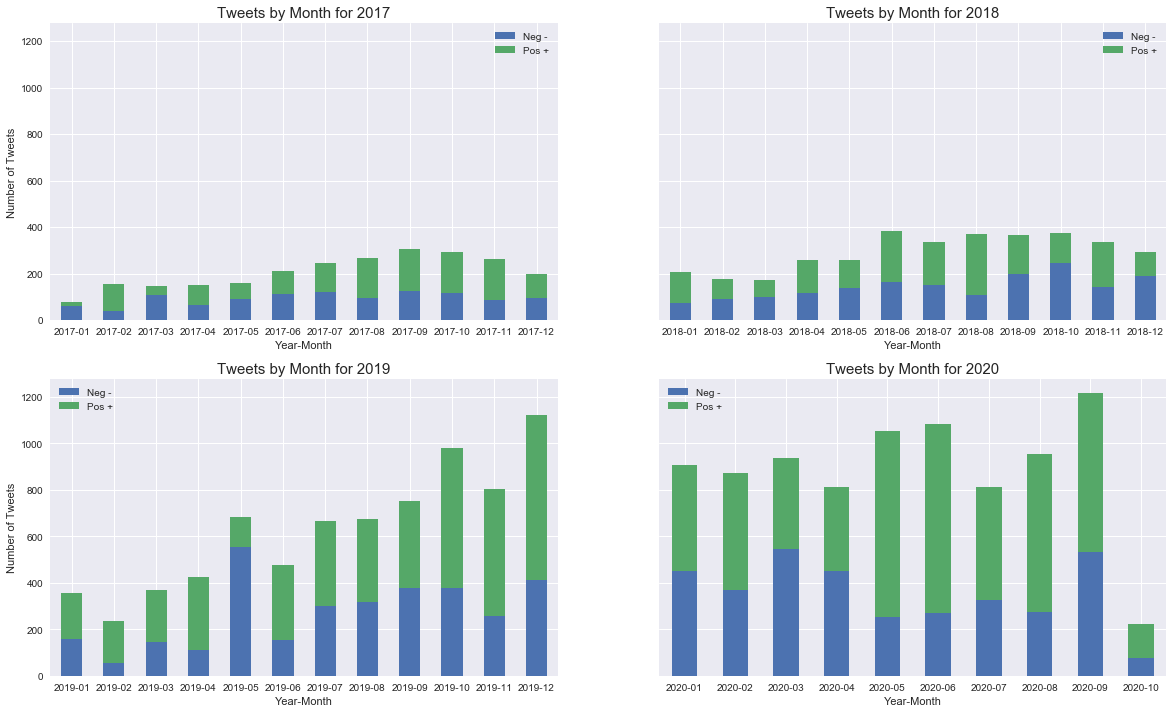

In [67]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    year_month = tweets[tweets["year"] == year]
    year_month = year_month[["year_month", "text", "target"]].groupby(["year_month", "target"]).count().unstack()
    year_month.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_xticklabels(year_month.index, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by Month for {year}", fontsize=15)
    ax[i].legend(labels=["Neg -", "Pos +"])
    


### Tweet count by day of week

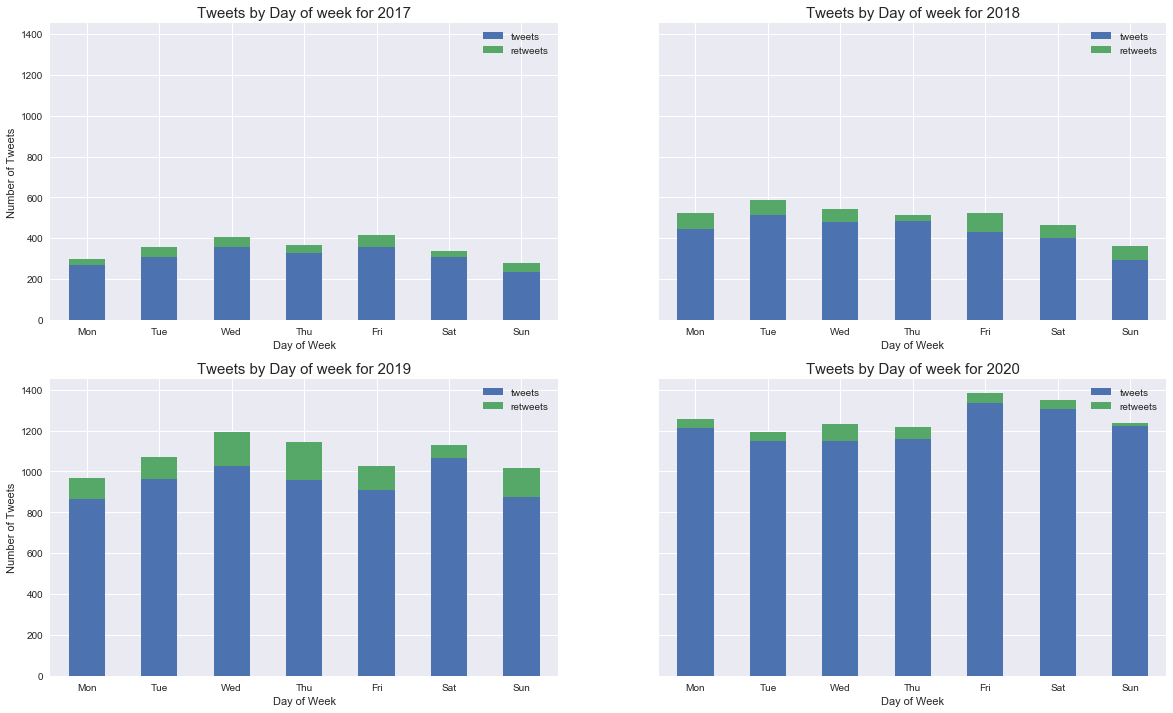

In [68]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    day_of_week = tweets[tweets["year"] == year]
    day_of_week = day_of_week[["day_of_week", "text", "is_retweet"]].groupby(["day_of_week", "is_retweet"]).count().unstack()
    day_of_week.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Day of Week")
    day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax[i].set_xticklabels(day_labels, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by Day of week for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    


We observed that President Trump usually tweets more on friday than any other day of the week. 

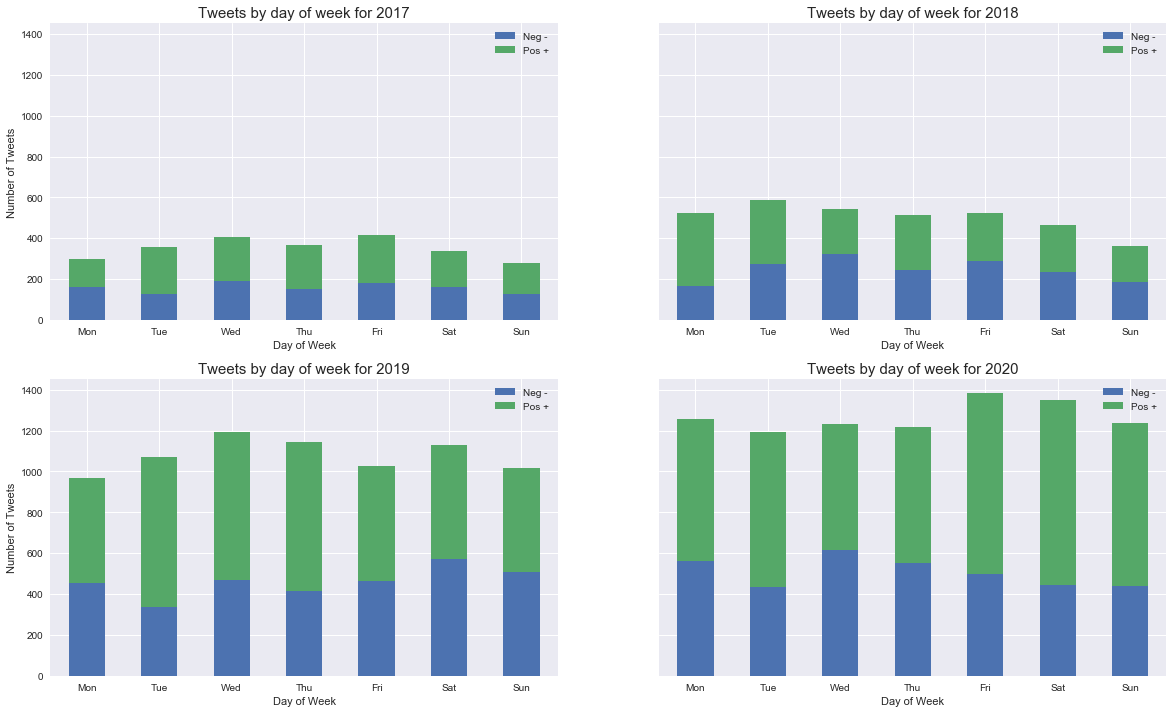

In [69]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    day_of_week = tweets[tweets["year"] == year]
    day_of_week = day_of_week[["day_of_week", "text", "target"]].groupby(["day_of_week", "target"]).count().unstack()
    day_of_week.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Day of Week")
    day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax[i].set_xticklabels(day_labels, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by day of week for {year}", fontsize=15)
    ax[i].legend(labels=["Neg -", "Pos +"])
    


### Tweet count by hour of day

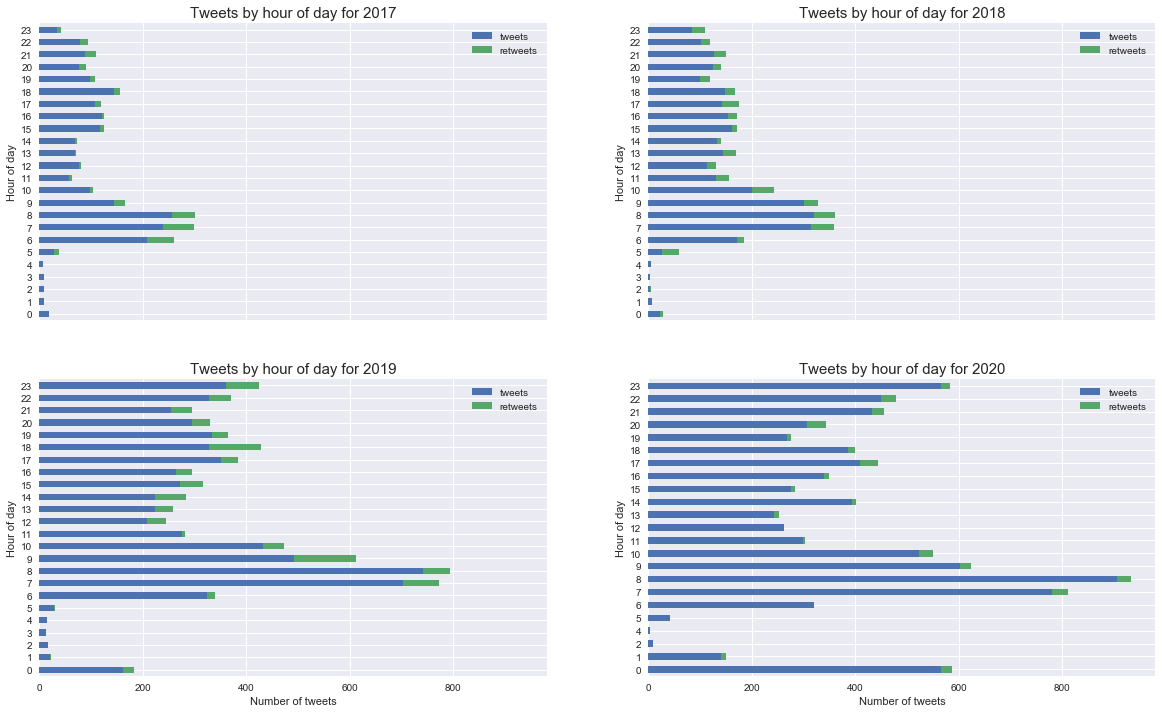

In [70]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharex="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    hour_of_day = tweets[tweets["year"] == year]
    hour_of_day = hour_of_day[["hour_of_day", "text", "is_retweet"]].groupby(["hour_of_day", "is_retweet"]).count().unstack()
    hour_of_day.plot(kind='barh',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Number of tweets")
    ax[i].set_ylabel("Hour of day")
    ax[i].set_title(f"Tweets by hour of day for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    

President Trump is most active betweeen 6am to 8am everyday. Most of his tweets are posted during this period in the past 4 years. 

### Top 10 most likes Tweets

Text(0.5, 1.0, 'Top 10 most likes Tweets')

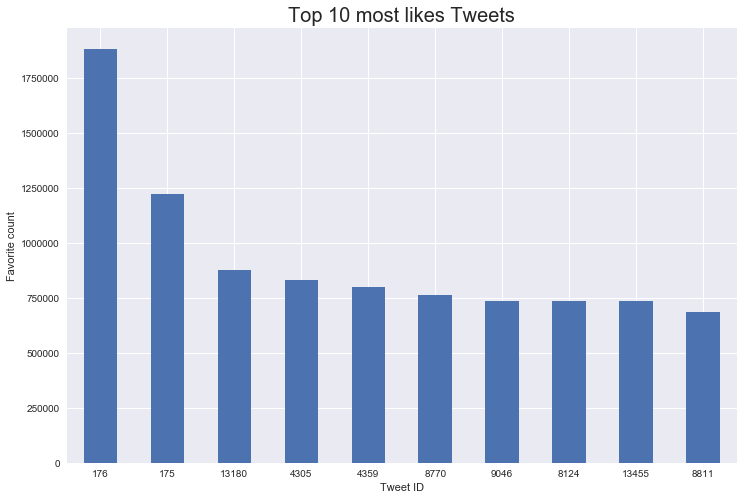

In [71]:
fig,ax = plt.subplots(figsize=(12,8))
fav_tweets = tweets["favorite_count"].sort_values(ascending=False)[:10]
fav_tweets.plot(kind='bar')
ax.set_xlabel("Tweet ID")
ax.set_xticklabels(fav_tweets.index, rotation=0)
ax.set_ylabel("Favorite count")
ax.set_title("Top 10 most likes Tweets", fontsize=20)

In [72]:
for i, index in enumerate(fav_tweets.index):
    print(f" Number {i+1}:\n {tweets.iloc[index].text}")
    print("")

 Number 1:
 Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

 Number 2:
 Going welI, I think! Thank you to all. LOVE!!!

 Number 3:
 A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!

 Number 4:
 The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 5:
 CHINA!

 Number 6:
 All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties &amp; damages taking place now. So far, so good! We have the most powerful and well equipped military anywhere in the world, by far! I will be making a statement tomorrow morning.

 Number 7:
 MERRY CHRISTMAS!

 Number 8:
 Kobe Bryant, despite being one of the truly great basketball players of all time, was just getting started in life. He loved his family so much, and had such strong passion for t

### Top 10 most mentioned

Text(0.5, 1.0, 'Top 10 most mentioned')

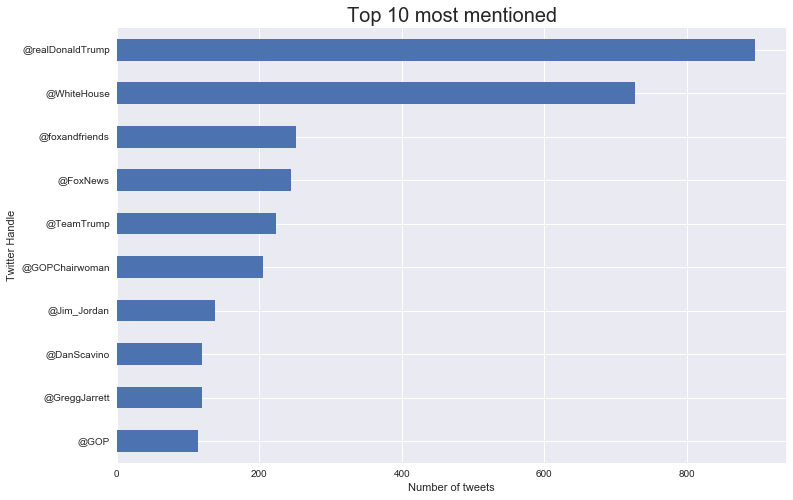

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
tweets["handle"].value_counts()[:10].sort_values().plot(kind='barh')
ax.set_xlabel("Number of tweets")
ax.set_ylabel("Twitter Handle")
ax.set_title("Top 10 most mentioned", fontsize=20)

Surprisingly President Trump retweet his own tweets the most follow by the whitehouse's tweets. 

### Top 10 most retweeted

Text(0, 0.5, 'Number of Tweets')

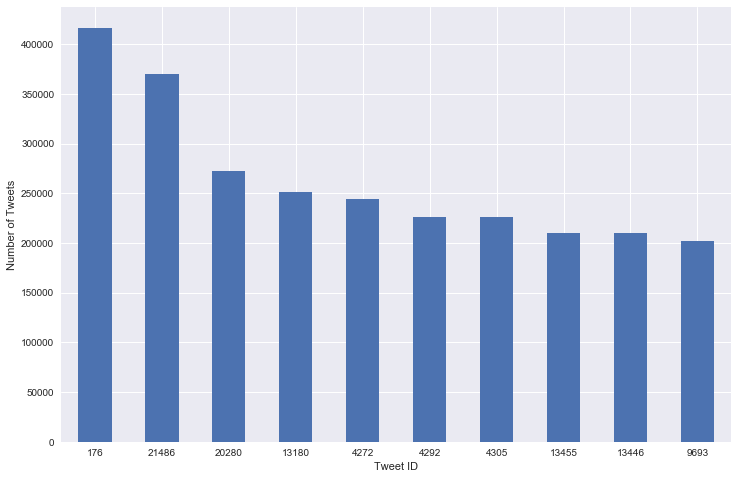

In [74]:
fig, ax = plt.subplots(figsize=(12,8))
top_retweets = tweets["retweet_count"].sort_values(ascending=False).head(10)
top_retweets.plot(kind="bar")
ax.set_xlabel("Tweet ID")
ax.set_xticklabels(top_retweets.index, rotation=0)
ax.set_ylabel("Number of Tweets")

In [75]:
for i, index in enumerate(top_retweets.index):
    print(f" Number {i+1}:\n {tweets.iloc[index].text}")
    print("")

 Number 1:
 Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

 Number 2:
 #FraudNewsCNN #FNN https://t.co/WYUnHjjUjg

 Number 3:
 Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen!

 Number 4:
 A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!

 Number 5:
 RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA

 Number 6:
 RT @realDonaldTrump: The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 7:
 The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 8:
 Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helpi

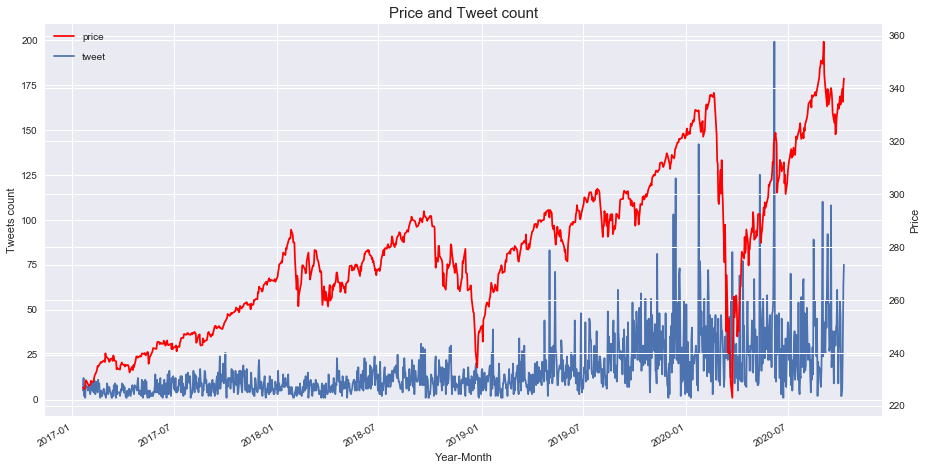

In [76]:
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()
market['close'].plot(ax=ax2, c='r')
ax2.set_ylabel('Price')
tweets[['text', 'trade_date']].groupby('trade_date').count().plot(ax=ax)
ax.set_xlabel('Year-Month')
ax.set_ylabel('Tweets count')
ax.set_title('Price and Tweet count', fontsize=15)
ax.legend(["tweet"], loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.legend(['price'])

Based on the graph we observed that the market react quite negatively after President Trump tweets alot. This can be seen in around 2019-06, 2020-02 and 2020-07 when there's there's a spike in number of tweets the price actually went down. However this might also be due to other factors.

### Distribution of words count

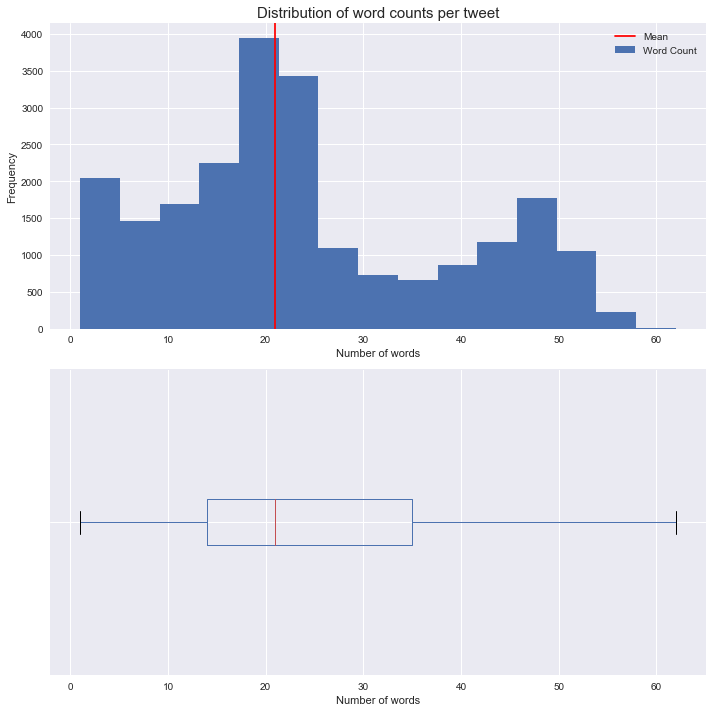

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
tweets['word_count'].plot(kind='hist', bins=15, ax=ax1, label='Word Count')
ax1.axvline(x=tweets['word_count'].median(), c='r', label='Mean')
ax1.set_xlabel('Number of words')
ax1.set_title('Distribution of word counts per tweet', fontsize=15)
ax1.legend()
tweets['word_count'].plot(kind='box', label='Word Count', ax=ax2, vert=False)
ax2.set_xlabel('Number of words')
ax2.set_yticklabels(" ")
plt.tight_layout()

In [78]:
tweets[['word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,22394.0,24.174243,14.355973,1.0,14.0,21.0,35.0,62.0


The distribution of words count seem to be skewed slightly to the right and the median is shown by the red vertical line indicate that President Trump has an median count of 21 words each tweet. The max word count Trump ever posted was 62 words and lowest is 1. Tweets less than 3 word count is consider as noise and wil be dropped.

### Distribution of tweets count

Text(0.5, 0, 'Number of tweets')

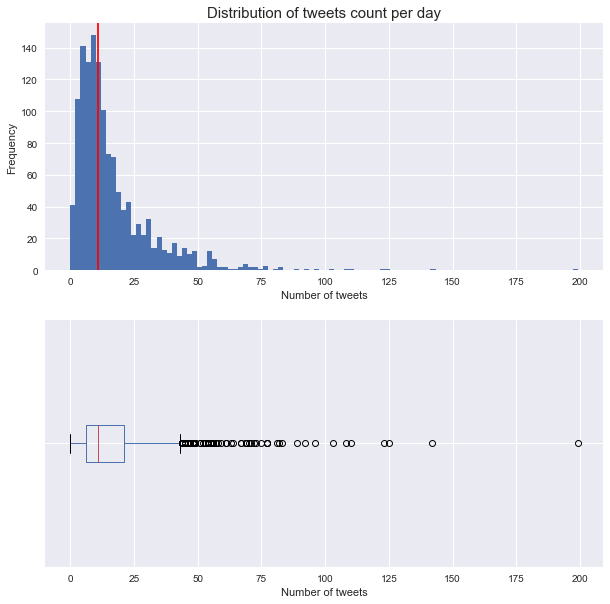

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
tweets.resample('D', on='created_at').count()['text'].plot(kind='hist', bins=100, ax=ax1)
ax1.set_xlabel('Number of tweets')
ax1.axvline(x=tweets.resample('D', on='created_at').count()['text'].median(), c='r', label='Mean')
ax1.set_title('Distribution of tweets count per day', fontsize=15)
tweets.resample('D', on='created_at').count()['text'].plot(kind='box', ax=ax2, vert=False)
ax2.set_yticklabels("")
ax2.set_xlabel('Number of tweets')

In [80]:
#average tweet per day since presidency
tweets.resample('D', on='created_at').count()[['text']].describe().T

,count,mean,std,min,25%,50%,75%,max
text,1358.0,16.490427,16.777959,0.0,6.0,11.0,21.0,199.0


The distribution is right skewed indicate that there might have outliers. President Trump post 11 tweets on average a day but interestingly on one occasion, he posted a breaking record of 198 tweets in a single day. 

Text(0.5, 1.0, 'Performance of market and number of tweets')

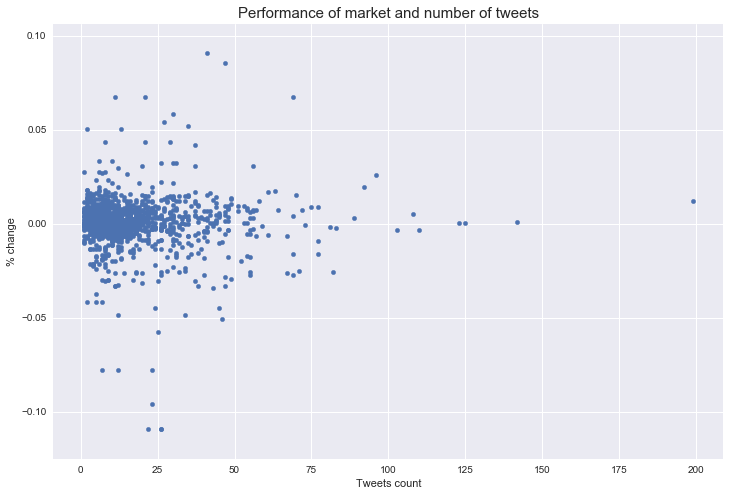

In [81]:
fig, ax = plt.subplots(figsize=(12,8))
mask = tweets[['text', 'change_pc', 'trade_date']].groupby(['change_pc', 'trade_date']).count().droplevel(1).reset_index()
mask.plot(kind='scatter', x='text', y='change_pc', ax=ax)
ax.set_xlabel('Tweets count')
ax.set_ylabel('% change')
ax.set_title('Performance of market and number of tweets', fontsize=15)

It doesn't seems to have any obvious relationship between the number of tweets posted a day with the market performance. We can see that most of the data points are cluster below 20 tweets and between -2 to 2% changes in the market. 

### Character Count

In [82]:
tweets['char_count'] = tweets['clean_text'].apply(len)

[]

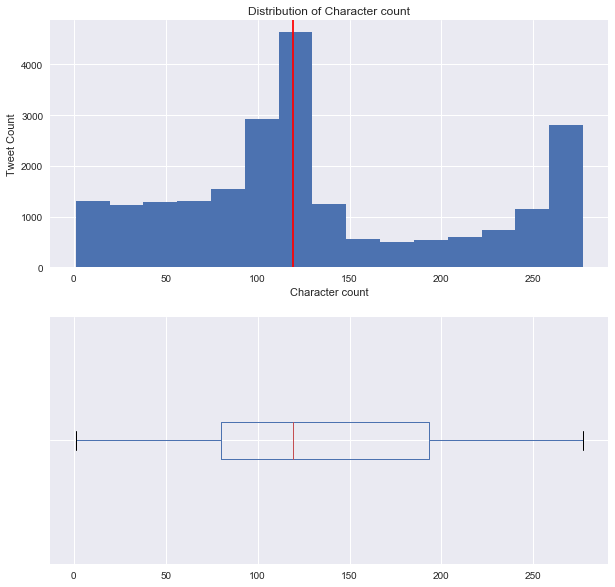

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))

tweets['char_count'].plot(kind='hist', bins=15, ax=ax1)
ax1.set_title('Distribution of Character count')
ax1.set_xlabel('Character count')
ax1.set_ylabel('Tweet Count')
ax1.axvline(tweets['char_count'].median(), c='r')

tweets['char_count'].plot(kind='box', ax=ax2, vert=False)
ax2.set_yticklabels('')


In [84]:
tweets[['char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,22394.0,132.643521,78.135155,1.0,80.0,119.0,193.0,277.0


President Trump tweets on average 119 characters. Which most tweets between 100 to 120 characters. Highest character count is 299 and lowest is 1. Tweets with low character count will have to be investigate further before fitting into our model as it might not provide useful information.

### Word Cloud

In [85]:
#join all tweets into a single text
long_text = " ".join(text for text in tweets.loc[:, 'clean_text'])

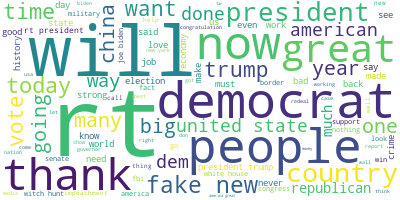

In [86]:
#Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, 
                      contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_text)

# Visualize the word cloud
wordcloud.to_image()

We make a word cloud to get a visual representation of most common words used by President Trump. It is also a key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary. Words like 'will', 'rt', 'now' and many more seems to appear more than i expected. Hence it's important to pre process the data before we do further analysis.

After analyzing the bag of words I have decided to manually add in stopwords that will affect the modelling at the later part as it has appear too many times.

['rt', 'great', 'thank', 'just', 'president','want', 'trump', 'new', 'today', 'big', 'make','people', 'time' , 'democrats', 'fake', 'news', 'america','american','time', 'like']

In [87]:
nlp = spacy.load('en_core_web_sm')


In [88]:
my_additional_stop_words = {'rt', 'great', 'thank', 'just', 'president',
                            'want', 'trump', 'new', 'today', 'big', 'make',
                            'people', 'time' , 'democrat', 'democrats', 
                            'fake', 'news', 'america',
                            'american','time', 'like', 'year', 'country'}
nlp.Defaults.stop_words |= my_additional_stop_words
stopwords = nlp.Defaults.stop_words

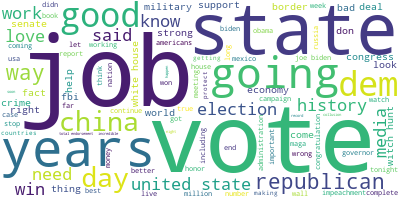

In [89]:
#Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, 
                      contour_width=3, contour_color='steelblue', stopwords=stopwords)
# Generate a word cloud
wordcloud.generate(long_text)

# Visualize the word cloud
wordcloud.to_image()

### Bag of words

Here we look at the top 10 most common word use by President Trump

In [90]:
#initialize the count vectorizer
cvec = CountVectorizer(stop_words=stopwords)

In [91]:
text_data = cvec.fit_transform(tweets['clean_text'])

/Users/jeremytan/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [92]:
text_data.shape

(22394, 18207)

In [93]:
text_data = pd.DataFrame(text_data.todense(), columns=cvec.get_feature_names())

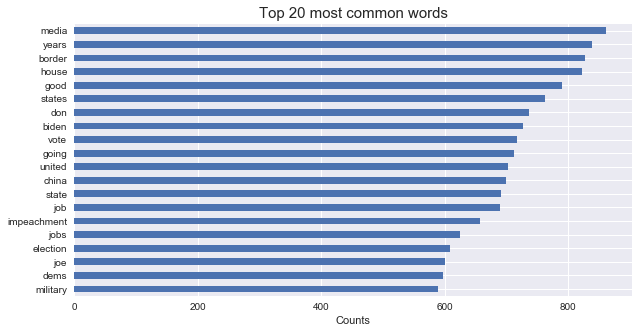

In [94]:
fig, ax = plt.subplots(figsize=(10,5))
common_words = text_data.sum(axis=0).sort_values(ascending=False).head(20)
common_words.plot(kind='barh', ax=ax)
ax.set_xlabel('Counts')
ax.set_title('Top 20 most common words', fontsize=15)
ax.invert_yaxis()

In [95]:
#save to csv
tweets.to_csv('../datasets/cleaned_tweets.csv', index=False)
market.to_csv('../datasets/cleaned_market.csv')